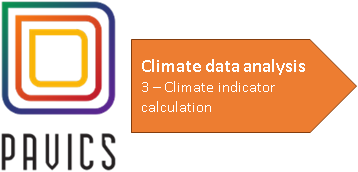

In this third tutorial we will demonstate PAVICS tools for calculating climate indicators, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS incorporates the [xclim](https://xclim.readthedocs.io/en/stable/) library which essentially has two layers for the calculation of indicators. The first `xclim.indices` is a core layer and containing the various algorithms and calculation logic, as well as any potential unit conversions.  A second layer consists of `xclim.core.indicator.Indicator` instances that essentially perform the same computations found in `xclim.indices`, but also run a number of health checks on input data and assign attributes to the output arrays. Indicators are split into realms (`atmos`, `land`, `seaIce`), according to the variables they operate on. 

This tutorial uses [xclim's](https://xclim.readthedocs.io/en/stable/) `atmos` module outlining steps for:

* Climate indicator calculation
* Missing data checks

Advac

We re-use part of the data-access and subset tutorials to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.
___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*

,Array,Chunk
Bytes,222.22 MB,744.19 kB
Shape,"(55115, 12, 84)","(323, 12, 48)"
Count,1369 Tasks,342 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,222.22 MB,744.19 kB
Shape,"(55115, 12, 84)","(323, 12, 48)"
Count,1369 Tasks,342 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


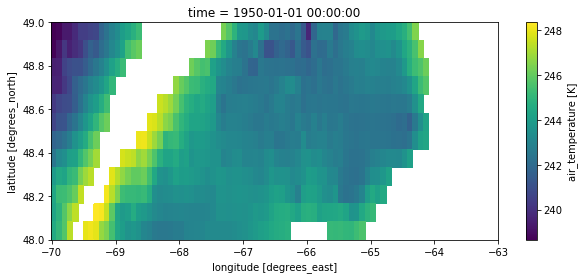

In [112]:
from siphon.catalog import TDSCatalog
from clisops.core import subset
import xarray as xr

url = "http://pavics.ouranos.ca:8083/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"

# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec
# This does not download the entire dataset, just the metadata and attributes describing the content. 
lon_bnds = [-70, -63]
lat_bnds = [48, 49]
ds = subset.subset_bbox(xr.open_dataset(cat.datasets[0].access_urls["OPENDAP"], chunks='auto'), lon_bnds=lon_bnds, lat_bnds=lat_bnds)

# What we see here is an in-memory representation of the full content, the actual data is still on the server.
display(ds)

# plot of single day tasmin
ds.tasmin.isel(time=0).plot(figsize=(10,4))

### Climate indicator calculation

The `atmos` module allows us to easily calculate a large number of climate indicators. For example we can determine the projected the number of days with maximum temperature above a threshold for our test dataset using the `atmos.tx_days_above`.  The vast majority of `xclim.atmos` calculations employ a resample frequency parameter `freq` trivializing the calculation of yearly, monthly, seasonal or other custom outputs    

calculating yearly output using freq="YS"
[########################################] | 100% Completed |  9.5s
[########################################] | 100% Completed |  1.6s


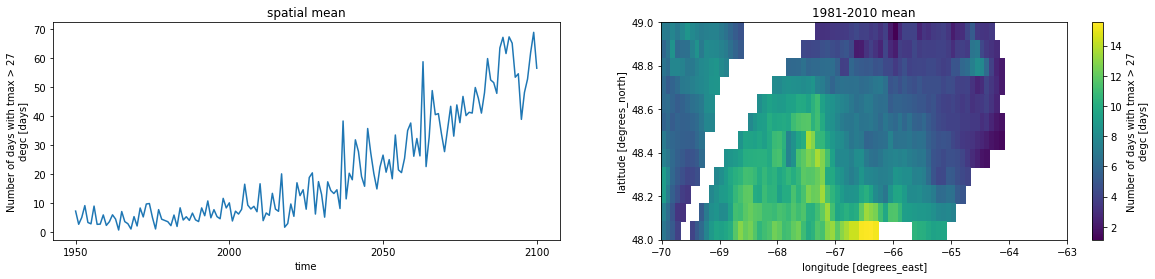

In [125]:
from xclim import atmos
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import warnings
warnings.simplefilter("ignore")

with ProgressBar():
    
    print(f'calculating yearly output using freq="YS"')
    out = atmos.tx_days_above(tasmax=ds.tasmax, thresh='27 degC', freq='YS') # Yearly frequency
    # Avergae over spatial domain and plot
    fig1 = plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    out.mean(dim=['lon','lat'], keep_attrs=True).plot()
    plt.title('spatial mean')
    plt.subplot(1,2,2)
    subset.subset_time(out, start_date='1981', end_date='2010').mean(dim='time', keep_attrs=True).plot()
    plt.title('1981-2010 mean')

Calculate seasonal output using freq="QS-DEC" ...
Calculate monthly output using freq="MS" ...
Calculate annual_starting_july output using freq="AS-JUL" ...
Calculate six_month output using freq="6MS" ...




Text(0.5, 1.0, '6 month output')

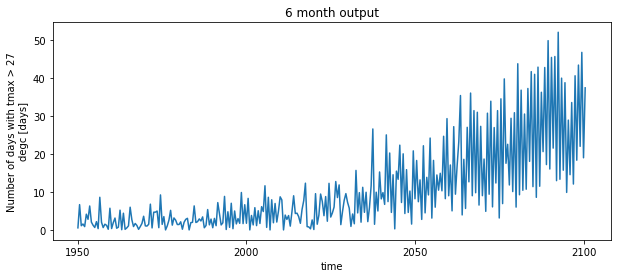

In [126]:
# Other common output frequencies
freqs = dict(seasonal='QS-DEC', monthly='MS',annual_starting_july='AS-JUL', six_month='6MS')
out = {}
for f, freq in freqs.items():
    print(f'Calculate {f} output using freq="{freq}" ...')
    out[freq] = atmos.tx_days_above(tasmax=ds.tasmax, thresh='27 degC', freq=freq)

# display 6-month
print('\n')
out['6MS'].mean(dim=['lon','lat'], keep_attrs=True).plot(figsize=(10,4))
plt.title('6 month output')

### Comparison of `xclim.atmos` vs `xclim.indices`

* provides addtional metadata attributes to the results

In [40]:
# calculate 

from xclim import indices as xci

display(xci.tx_days_above(tasmax=ds.tasmax, thresh='28 degC', freq='YS'))# Annual frequency
display(atmos.tx_days_above(tasmax=ds.tasmax, thresh='28 degC', freq='YS'))

{'units': 'days'}

/home/logan/anaconda3/envs/xclim/lib/python3.8/site-packages/xclim/indicators/atmos/_temperature.py:87: UserWarning: Variable does not have a `cell_methods` attribute.
  cfchecks.check_valid(tasmax, "cell_methods", "*time: maximum within days*")


{'units': 'days',
 'cell_methods': ' time: maximum within days time: sum over days',
 'xclim_history': "[2021-01-18 15:32:16] tx_days_above: tx_days_above(tasmax=<array>, thresh='28 degC', freq='YS') - xclim version: 0.22.0.",
 'standard_name': 'number_of_days_with_air_temperature_above_threshold',
 'long_name': 'Number of days with tmax > 28 degc',
 'description': 'Annual number of days where daily maximum temperature exceeds 28 degc.'}